# Clustering

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/206-clustering.ipynb)

This notebook contains the simple examples of timeseries clustering using ETNA library.

**Table of contents**

* [Generating dataset](#chapter1)  
* [Distances](#chapter2)   
* [Clustering](#chapter3)
    * [Building Distance Matrix](#section_3_1)
    * [Building Clustering algorithm](#section_3_2)
    * [Predicting clusters](#section_3_3)
    * [Getting centroids](#section_3_4)
* [Advanced: Custom Distance](#chapter4)
    * [Custom Distance implementation](#section_4_1)
    * [Custom Distance in clustering](#section_4_2)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from etna.datasets import TSDataset

## 1. Generating dataset <a class="anchor" id="chapter1"></a>

In this notebook we will work with the toy dataset generated from Normal distribution. Timeseries are naturally separated into clusters based on the mean value.

In [3]:
def gen_dataset():
    df = pd.DataFrame()
    for i in range(1, 5):
        date_range = pd.date_range("2020-01-01", "2020-05-01")
        for j, sigma in enumerate([0.1, 0.3, 0.5, 0.8]):
            tmp = pd.DataFrame({"timestamp": date_range})
            tmp["segment"] = f"{2*i}{j}"
            tmp["target"] = np.random.normal(2 * i, sigma, len(tmp))
            df = pd.concat([df, tmp], ignore_index=True)
    ts = TSDataset(df=df, freq="D")
    return ts

Let's take a look at the dataset

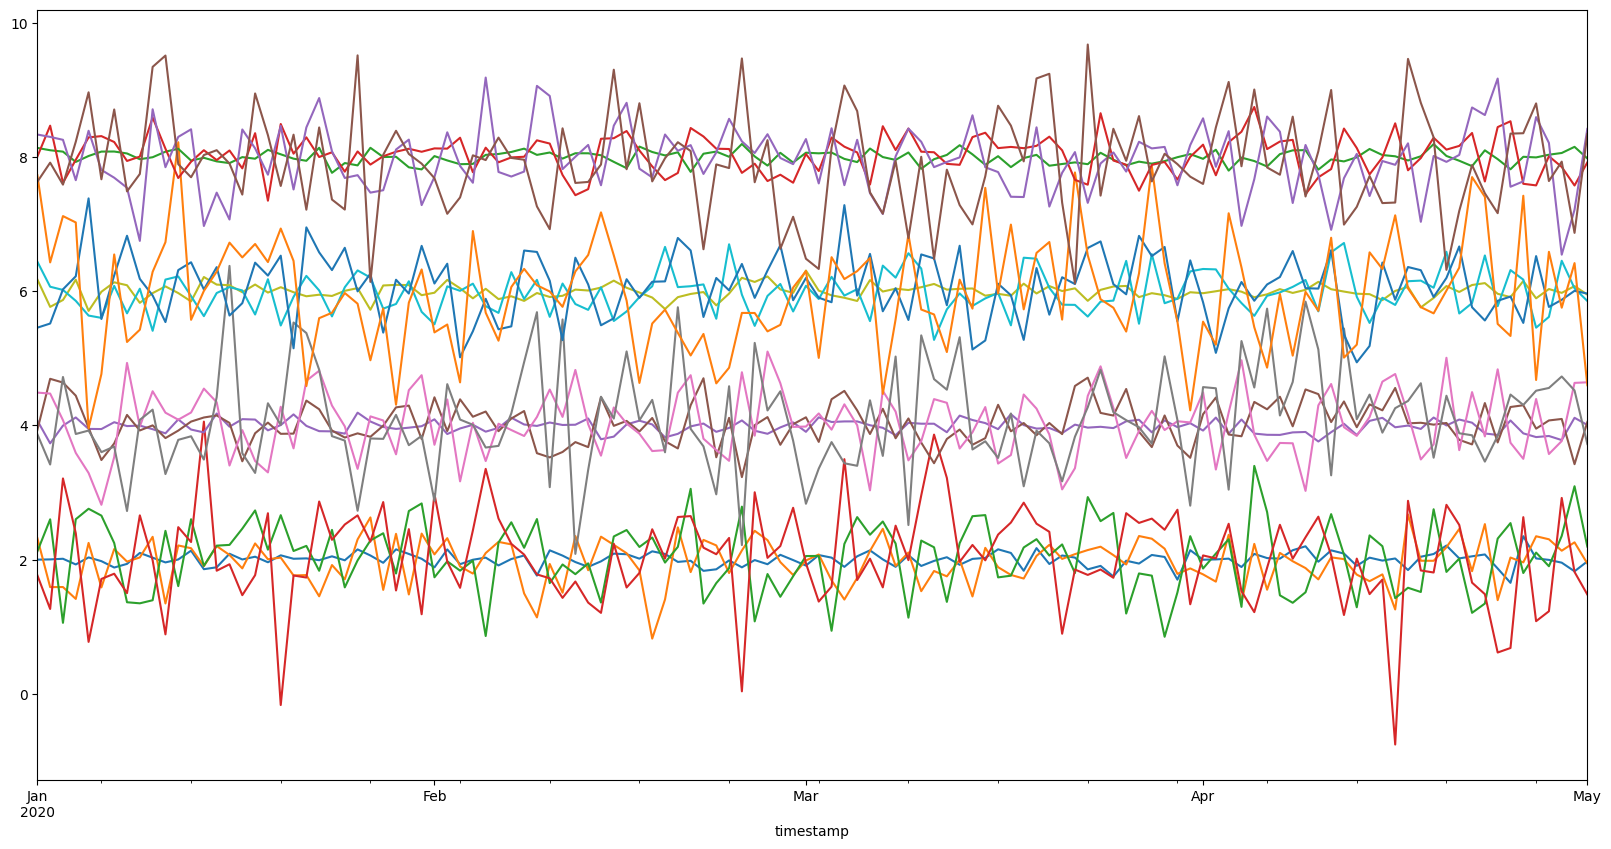

In [4]:
ts = gen_dataset()
df = ts.to_pandas()
df.plot(figsize=(20, 10), legend=False);

As you can see, there are about four clusters here. However, usually it is not obvious how to separate the timeseries into the clusters. Therefore, we might want to use clustering algorithms to help us.

## 2. Distance<a class="anchor" id="chapter2"></a>
In order to combine series into clusters, it is necessary to set the distance function on them. Distances implement the `Distance` interface and can be computed for two `pd.Series` indexed by `timestamp`.

In our library we provide implementation of [Euclidean](https://en.wikipedia.org/wiki/Euclidean_distance) and [DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) Distances

In [5]:
from etna.clustering import DTWDistance
from etna.clustering import EuclideanDistance

In [6]:
x1 = pd.Series(
    data=[0, 0, 1, 2, 3, 4, 5, 6, 7, 8],
    index=pd.date_range("2020-01-01", periods=10),
)
x2 = pd.Series(
    data=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    index=pd.date_range("2020-01-02", periods=10),
)

Distance calculation in the case of different timestamps can be performed in two modes:

* `trim_series = True` - calculate the distance only over the common part of the series. Common part is defined based on the timestamp index.

In [7]:
distance = EuclideanDistance(trim_series=True)
distance(x1, x2)  # Series are the same in the common part of the timestamps

0.0

* `trim_series = False` - calculate the distance over the whole series, ignoring the timestamp. The same as dropping the timestamp index and using the integer index as in the common array.

In [8]:
distance = EuclideanDistance(trim_series=False)
distance(x1, x2)

3.0

For better understanding, take a look at the visualization below.

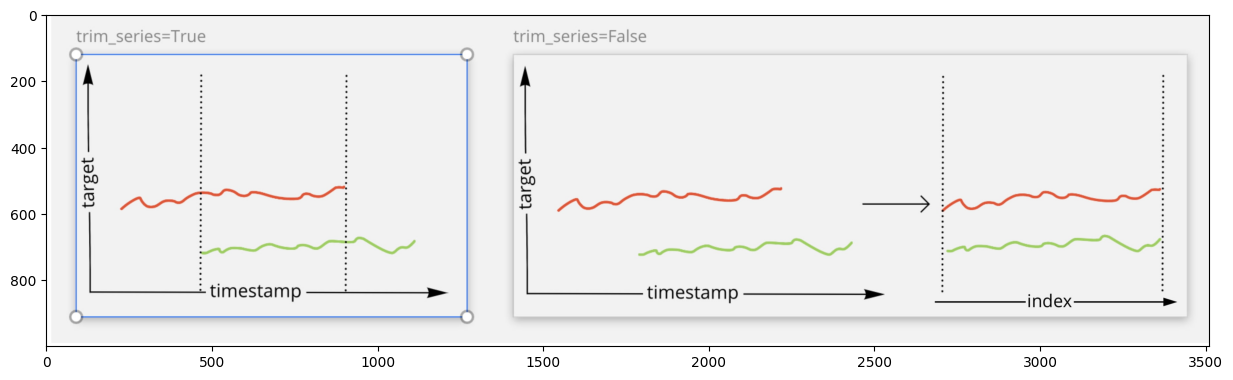

In [9]:
_ = plt.subplots(figsize=(15, 10))
img = plt.imread("./assets/clustering/trim_series.jpg")
plt.imshow(img);

Let's calculate different Distances with setting `trim_series` parameter to see the difference

In [10]:
distances = pd.DataFrame()
distances["Euclidean"] = [
    EuclideanDistance(trim_series=True)(x1, x2),
    EuclideanDistance(trim_series=False)(x1, x2),
]
distances["DTW"] = [
    DTWDistance(trim_series=True)(x1, x2),
    DTWDistance(trim_series=False)(x1, x2),
]
distances["trim_series"] = [True, False]
distances.set_index("trim_series", inplace=True)
distances

,Euclidean,DTW
trim_series,,
True,0.0,0.0
False,3.0,1.0


## 3. Clustering <a class="anchor" id="chapter3"></a>

Our library provides a class for so called *hierarchical clustering*, which has two built-in implementations for different Distances. 

In [11]:
from etna.clustering import EuclideanClustering

*Hierarchical clustering* consists of three stages:

1. Building a matrix of pairwise distances between series (`build_distance_matrix`)
2. Initializing the clustering algorithm (`build_clustering_algo`) 
3. Training the clustering algorithm and predicting clusters (`fit_predict`)

In this section you will find the description of step by step clustering process. 

### 3.1 Building Distance Matrix<a class="anchor" id="section_3_1"></a>

On the first step we need to build the so-called *Distance matrix* containing the pairwise distances between the timeseries in the dataset. Note, that this is **the most time-consuming part** of the clustering process, and it may take a long time to build a Distance matrix for a large dataset.

Distance matrix for the Euclidean distance

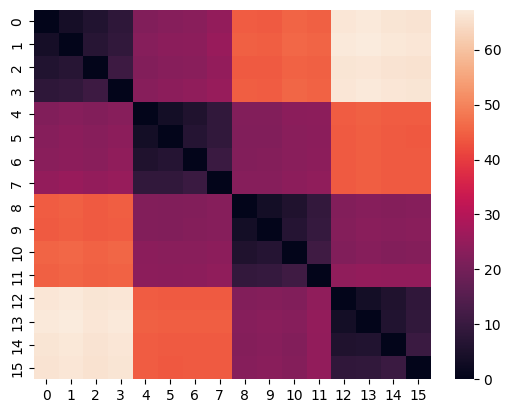

In [12]:
model = EuclideanClustering()
model.build_distance_matrix(ts=ts)
sns.heatmap(model.distance_matrix.matrix);

The Distance matrix is **computed ones** and saved in the instance of `HierarchicalClustering`. This makes it possible to change the clustering parameters without recalculating the Distance matrix.

### 3.2 Building Clustering algorithm <a class="anchor" id="section_3_2"></a>

After computing the Distance matrix, you need to set the parameters to the clustering algorithm, such as:

+ **n_clusters** - number of clusters
+ **linkage** - rule for distance computation for new clusters  

As the Distance matrix is build once, you can experiment with different parameters of the clustering algorithm without wasting time on its recomputation. 

In [13]:
model = EuclideanClustering()
model.build_distance_matrix(ts)

In [14]:
model.build_clustering_algo(n_clusters=4, linkage="average")

### 3.3 Predicting clusters<a class="anchor" id="section_3_3"></a>

The final step of the clustering process is cluster prediction. As the output of the `fit_predict` you get the mapping for segment to cluster.

In [15]:
segment2cluster = model.fit_predict()
segment2cluster

{'20': 3,
 '21': 3,
 '22': 3,
 '23': 3,
 '40': 1,
 '41': 1,
 '42': 1,
 '43': 1,
 '60': 0,
 '61': 0,
 '62': 0,
 '63': 0,
 '80': 2,
 '81': 2,
 '82': 2,
 '83': 2}

Let's visualize the results

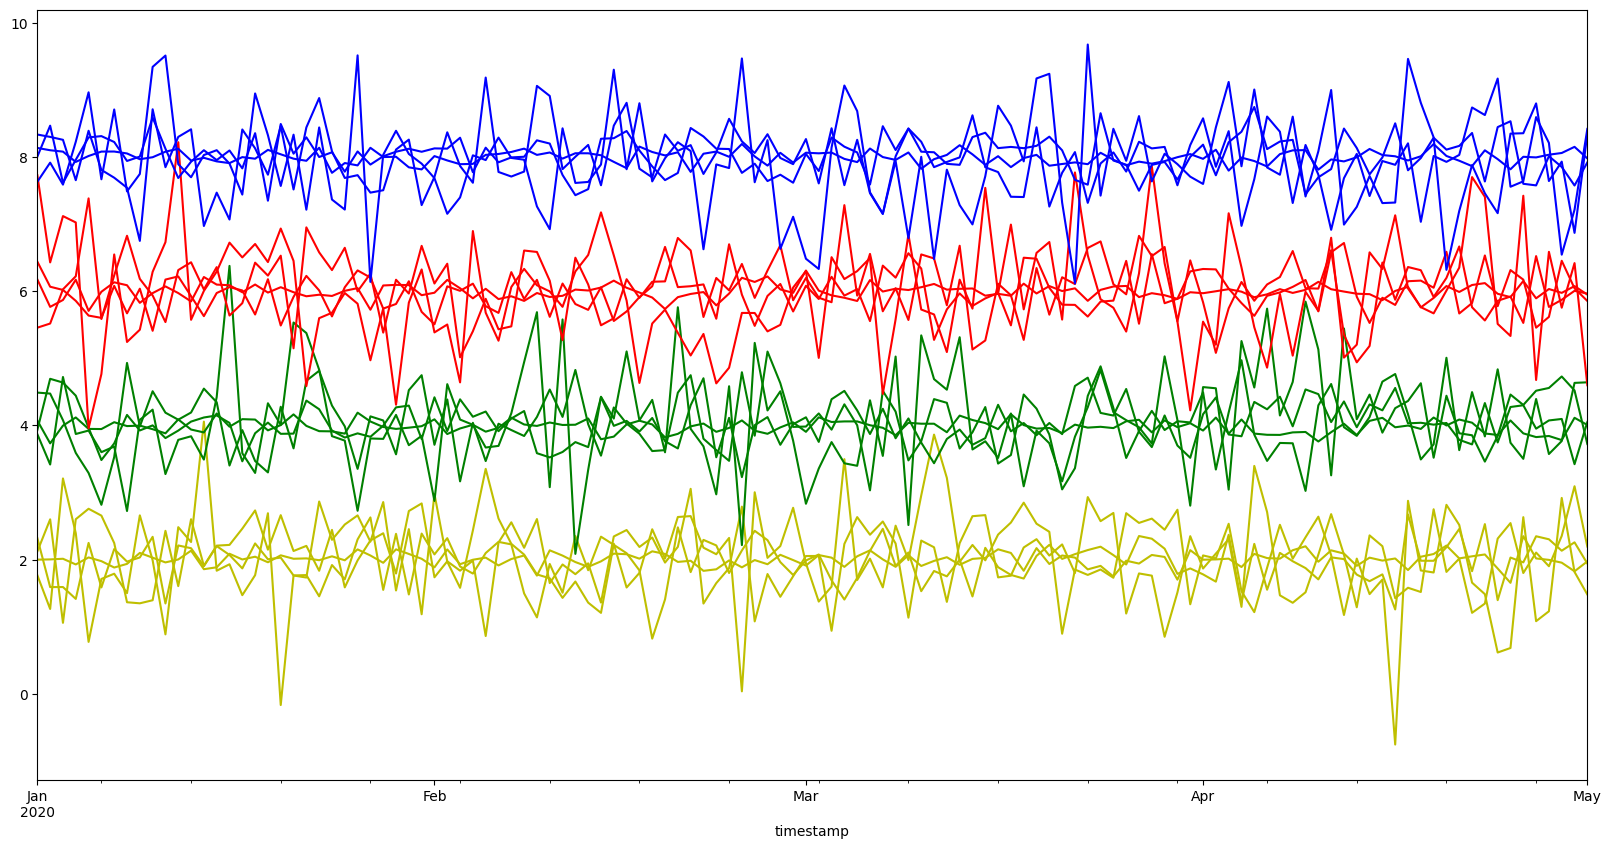

In [16]:
colores = ["r", "g", "b", "y"]
color = [colores[i] for i in segment2cluster.values()]
df = ts.to_pandas()
df.plot(figsize=(20, 10), color=color, legend=False);

### 3.4 Getting centroids<a class="anchor" id="section_3_4"></a>

In addition, it is possible to get the clusters centroids, which are the typical member of the corresponding cluster.

In [17]:
from etna.analysis import plot_clusters

In [18]:
centroids = model.get_centroids()
centroids.head()

cluster,0,1,2,3
feature,target,target,target,target
timestamp,,,,
2020-01-01,6.452557,4.091522,8.030402,2.051344
2020-01-02,5.947237,4.080386,8.199436,1.863703
2020-01-03,6.261150,4.359732,7.888462,1.966963
2020-01-04,6.321010,4.006700,7.945351,2.083608
2020-01-05,5.673015,3.782505,8.419567,1.952514


Finally, we can plot clusters along with centroids for visual assessment

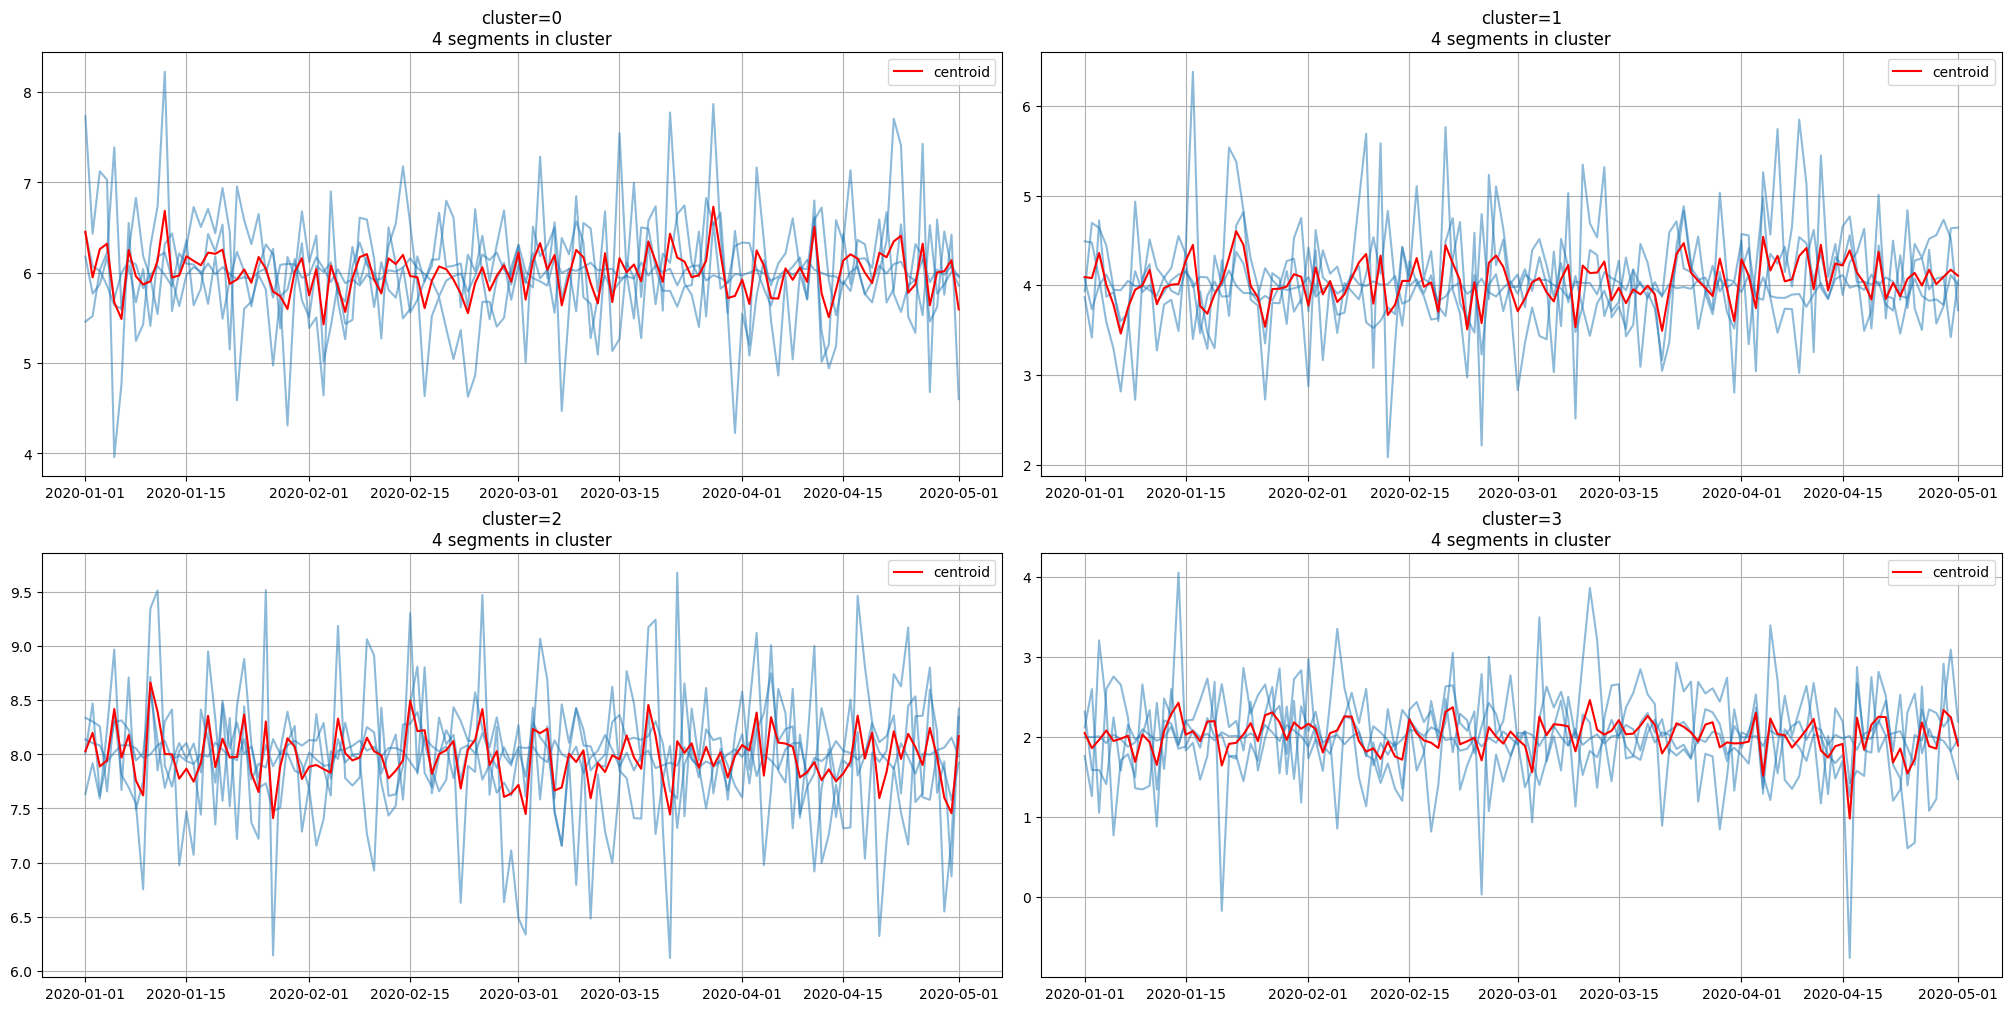

In [19]:
plot_clusters(ts, segment2cluster, centroids)

## 4. Advanced: Custom Distance<a class="anchor" id="chapter4"></a>

In addition to the built-in Distances, you are able to implement your own Distance. The example below shows how to implement the `Distance` interface for custom Distance.

### 4.1 Custom Distance implementation<a class="anchor" id="section_4_1"></a>

In [20]:
from etna.clustering import Distance


class MyDistance(Distance):
    def __init__(self, trim_series: bool = False):
        super().__init__(trim_series=trim_series)

    def _compute_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """Compute distance between x1 and x2."""
        return np.max(np.abs(x1 - x2))

    def _get_average(self, ts: "TSDataset") -> pd.DataFrame:
        """Get series that minimizes squared distance to given ones according to the distance."""
        df = ts.to_pandas()
        centroid = pd.DataFrame(
            {
                "timestamp": ts.timestamps.values,
                "target": df.median(axis=1).values,
            }
        )
        return centroid

In [21]:
distances = pd.DataFrame()
distances["MyDistance"] = [
    MyDistance(trim_series=True)(x1, x2),
    MyDistance(trim_series=False)(x1, x2),
]
distances["trim_series"] = [True, False]
distances.set_index("trim_series", inplace=True)
distances

,MyDistance
trim_series,
True,0
False,1


### 4.2 Custom Distance in clustering<a class="anchor" id="section_4_2"></a>

To specify the Distance in clustering algorithm you need to use the clustering base class `HierarchicalClustering`

In [22]:
from etna.clustering import HierarchicalClustering

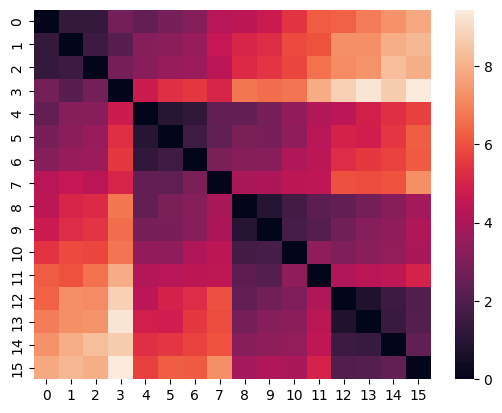

In [23]:
model = HierarchicalClustering(distance=MyDistance())
model.build_distance_matrix(ts=ts)
sns.heatmap(model.distance_matrix.matrix);

We can see a visualization for our custom distance.